In [41]:
# %matplotlib inline
import os
from pprint import pprint
import pickle
from collections import Counter
import statistics as stat
import pandas as pd 
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from scipy.sparse.linalg import eigs
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2grey
import matplotlib.pyplot as plt
import seaborn as sns

# plt.rcParams['figure.figsize'] = [8, 8]
# sns.set(style = "darkgrid")

%run fns.ipynb
%run visualize.ipynb

In [42]:
path = os.getcwd() + '/dataset/cifar-10-python/'

train_images, test_images, meta_data =  collect_data(path)
no_of_classes = 10

In [43]:
if not os.path.exists(os.getcwd()+'/data.pickle'):
    data = createDataMatrix(train_images)
    pickling(data, 'data')
else:
    train_data = unpickle('data')

In [44]:
# showDist(train_data)
# scale(train_data[:,:-1], axis=0, with_mean=True, with_std=True) # Standardize to check for gaussain accuracy
if not os.path.exists(os.getcwd()+'/test.pickle'):
    data = createDataMatrix(test_images)
    pickling(data, 'test')
else:
    test_data = unpickle('test')

/home/mayank/.local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


(50000, 1025)

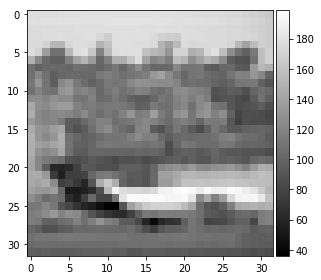

In [45]:
viewImg(np.reshape(train_data[0,:-1], (32,32)), True)  # To show data point
# train_data[2,-1]
train_data.shape

In [46]:
""" Classifying original dataset """
classify(train_data, test_data)

Accuracy:  0.2683


Mean of accuracy:  0.27244 Standard deviation of accuracy:  0.003505196142871326
Accuracy using best model on Test set:  0.2805


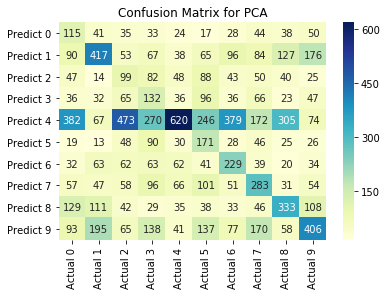

In [53]:
""" PCA """
K = 5
# eigen_energy = [0.95, 0.99, 0.90, 0.70]
eigen_energy = [0.95]

for eg in eigen_energy:
    pca_train, projection_mat = pca(train_data[:, :-1], eg)
    pca_test = np.dot(projection_mat, test_data[:, :-1].T).T
    
    pca_train = np.append(pca_train, train_data[:,-1][:,np.newaxis], axis = 1)
    pca_test = np.append(pca_test, test_data[:,-1][:,np.newaxis], axis = 1)

    selected_model = crossValidation(pca_train, K) # returns best model
    confusion_mat = classifyTestset(selected_model, pca_test)
    drawConfusionMatrix(confusion_mat, 'PCA')

In [55]:
projection_mat.shape

[{'num_cases_per_batch': 10000,
  'label_names': [b'airplane',
   b'automobile',
   b'bird',
   b'cat',
   b'deer',
   b'dog',
   b'frog',
   b'horse',
   b'ship',
   b'truck'],
  'num_vis': 3072}]

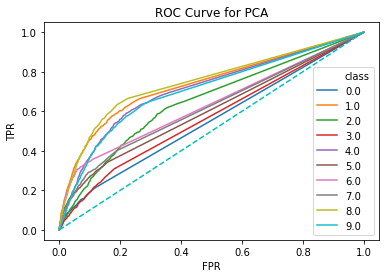

In [48]:
""" ROC on PCA Test data """
prb = selected_model.predict_proba(pca_test[:,:-1])
ROC(pca_test, prb, 'PCA') 

Mean of accuracy:  0.34952 Standard deviation of accuracy:  0.004868839697504934
Accuracy using best model on Test set:  0.2788


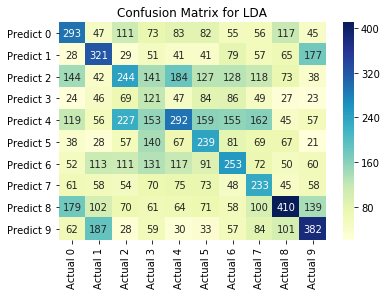

In [49]:
""" LDA """

lda_train, projection_matrix = LDA(train_data)
lda_train = lda_train.real

lda_test = np.dot(projection_matrix, test_data[:,:-1].T).T  
lda_test = lda_test.real

lda_test = np.append(lda_test, test_data[:,-1][:,np.newaxis], axis = 1)

best_model = crossValidation(lda_train, K)
confusion_matrix = classifyTestset(best_model, lda_test)
drawConfusionMatrix(confusion_matrix, 'LDA')

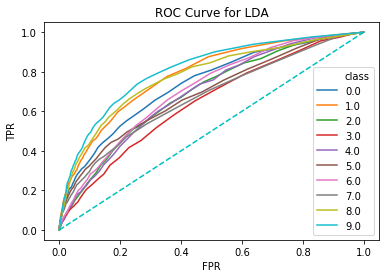

In [50]:
""" ROC on LDA Test data """
prb = best_model.predict_proba(lda_test[:,:-1])
ROC(lda_test, prb, 'LDA')

In [51]:
""" LDA on PCA projected data """
lda_pca_train, pr_mat1 = LDA(pca_train)
lda_pca_train = lda_pca_train.real  # lda() return train data with labels

lda_pca_test = np.dot(pr_mat1, pca_test[:,:-1].T).T  
lda_pca_test = lda_pca_test.real

lda_pca_test = np.append(lda_pca_test, pca_test[:,-1][:,np.newaxis], axis = 1)

classify(lda_pca_train, lda_pca_test)

Accuracy:  0.3004


In [52]:
""" PCA on LDA projected data """
pca_lda_train, pr_mat2 = pca(lda_train[:,:-1], 1)
pca_lda_train = pca_lda_train.real

pca_lda_train = np.append(pca_lda_train, lda_train[:,-1][:,np.newaxis], axis =1) # pca function doesn't return labels
pca_lda_test = np.dot(pr_mat2, lda_test[:,:-1].T).T  
pca_lda_test = pca_lda_test.real

pca_lda_test = np.append(pca_lda_test, lda_test[:,-1][:,np.newaxis], axis = 1)

classify(pca_lda_train, pca_lda_test)

Accuracy:  0.2782
